# Building A Fair Mahine Learning Model Using Reduction & Threshold Techniques For Loan Acceptance Prediction

#### Maintaining Accuracy While Providing Fairness in Loan Acceptance For Sensitive Attributes Like Race & Sex

##### By: Aurelio Barrios

## What is Shown In This Notebook

This is the notebook that will display the first of two machine learning models. This model will focus on fair loan acceptance rates across the sensitive attribute race. Then the model will further aim to provide fairness not only across race but fairness across sex within each race.

## What is Shown In This Project

- **Domain Of Project**
    - Domain for this project is related to financing and loan approval. The project will use data on loan acceptance to create machine learning models for future decisions, but will incorporate fairlearn models to make sure that the machine learning models deployed maintain fairness across race and sex.
- **Machine Learning Task**
    - Binary classification. Predict wether to accept or decline a loan application. 
- **Metrics**
    - The machine learning models will be evaluated using accuracy.
    - The fairlearn models will be evaluated using the following
        - Demographic parity difference
        - Equalized odds difference
        - Demographic parity ratio
        
### Imports

In [37]:
#General imports
import pandas as pd

#Visualization imports
import matplotlib.pyplot as plt

#Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#Fairlearn imports
from fairlearn.metrics import group_summary
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, demographic_parity_ratio
from fairlearn.metrics import difference_from_summary
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.postprocessing import plot_threshold_optimizer
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, DemographicParity
from fairlearn.widget import FairlearnDashboard

import warnings
warnings.filterwarnings('ignore')

### Data Reading & More Cleaning

In [4]:
df = pd.read_csv('data/race2_model.csv')
df.head()

,agency_abbr,loan_type_name,property_type_name,loan_purpose_name,owner_occupancy_name,loan_amount_000s,preapproval_name,msamd_name,county_name,census_tract_number,...,purchaser_type_name,hoepa_status_name,lien_status_name,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,target
0,CFPB,Conventional,One-to-four family dwelling (other than manufa...,Home improvement,Owner-occupied as a principal dwelling,570.0,Not applicable,"Sacramento, Roseville, Arden-Arcade - CA",Sacramento County,61.01,...,Loan was not originated or was not sold in cal...,Not a HOEPA loan,Secured by a first lien,4824.0,37.230000,75200.0,57.419998,818.0,1626.0,0
1,CFPB,Conventional,One-to-four family dwelling (other than manufa...,Home purchase,Not owner-occupied as a principal dwelling,185.0,Not applicable,"Riverside, San Bernardino, Ontario - CA",Riverside County,432.27,...,Loan was not originated or was not sold in cal...,Not a HOEPA loan,Secured by a first lien,7404.0,57.520000,63200.0,116.010002,1215.0,1743.0,0
2,HUD,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Owner-occupied as a principal dwelling,417.0,Not applicable,"Oakland, Hayward, Berkeley - CA",Contra Costa County,3020.08,...,Loan was not originated or was not sold in cal...,Not a HOEPA loan,Secured by a first lien,8787.0,65.129997,97400.0,97.269997,1463.0,2164.0,0
3,HUD,FHA-insured,One-to-four family dwelling (other than manufa...,Home purchase,Owner-occupied as a principal dwelling,325.0,Not applicable,"Riverside, San Bernardino, Ontario - CA",Riverside County,432.20,...,"Commercial bank, savings bank or savings assoc...",Not a HOEPA loan,Secured by a first lien,3944.0,52.000000,63200.0,75.089996,485.0,708.0,1
4,HUD,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Owner-occupied as a principal dwelling,424.0,Not applicable,Fresno - CA,Fresno County,14.09,...,Fannie Mae (FNMA),Not a HOEPA loan,Secured by a first lien,2063.0,61.950001,50000.0,193.210007,447.0,668.0,1


In [5]:
#drop columns
df = df.drop(['county_name', 'census_tract_number'], axis=1)

#sample from the original dataset as it is too large to process all of it
df = df.sample(n=100000, random_state=1)

In [6]:
#helper function that filters race so that applicant race is clear and established
def filter_helper(race):
    if 'appli' in race:
        return 1
    return 0

df['helper'] = df['applicant_race_name_1'].apply(filter_helper)

df = df[df['helper'] == 0]

df = df.drop(['helper'], axis=1)

df = df[df['purchaser_type_name'] != 'Farmer Mac (FAMC)']

In [7]:
df['applicant_race_name_1'].value_counts()

White                                        68288
Asian                                        15475
Black or African American                     4678
Native Hawaiian or Other Pacific Islander     1171
American Indian or Alaska Native              1025
Name: applicant_race_name_1, dtype: int64

### Data Exploration

In [8]:
#this shows loan acceptance rates (accepted = 1) per race category
prop_dict = {}
for i in df['applicant_race_name_1'].unique():
    curr_df = df[df['applicant_race_name_1'] == i]
    
    prop_dict[i] = curr_df['target'].value_counts(normalize=True).to_dict()
    
prop_dict

{'Asian': {1: 0.8272697899838449, 0: 0.1727302100161551},
 'White': {1: 0.811782450796626, 0: 0.18821754920337394},
 'Native Hawaiian or Other Pacific Islander': {1: 0.7301451750640479,
  0: 0.2698548249359522},
 'Black or African American': {1: 0.7148353997434801, 0: 0.2851646002565199},
 'American Indian or Alaska Native': {1: 0.6946341463414634,
  0: 0.3053658536585366}}

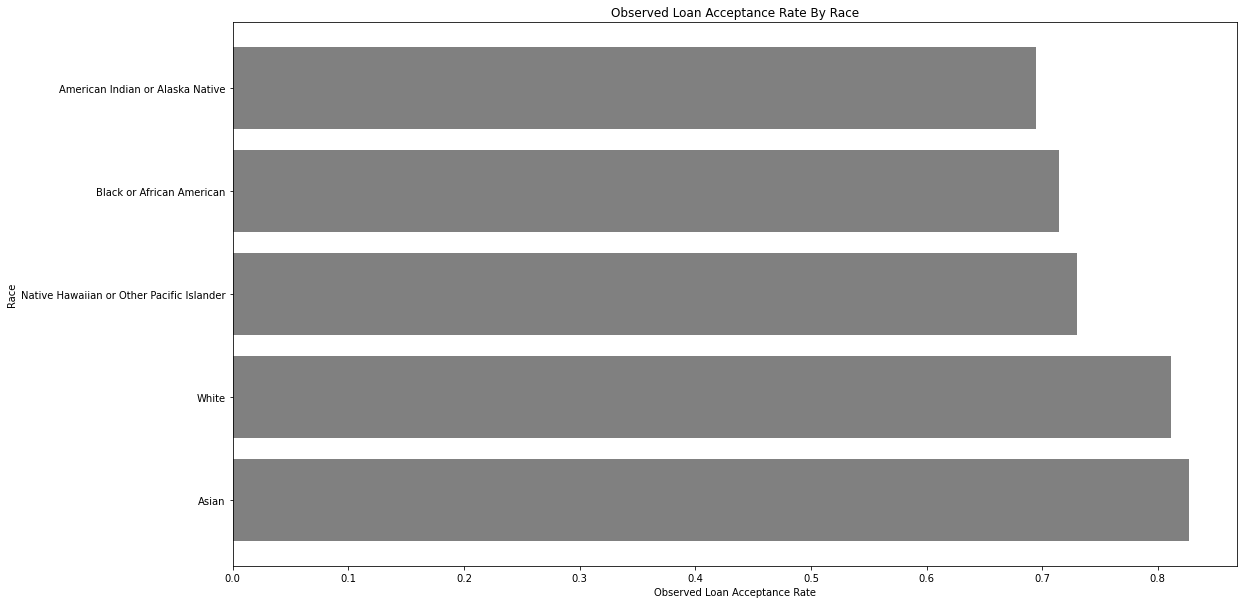

In [11]:
#visualization to help see acceptance rates per race
race_dict = []
acceptance_dict = []
for key in prop_dict:
    race_dict.append(key)
    acceptance_dict.append(prop_dict[key][1])
    
x_pos = [i for i, _ in enumerate(race_dict)]

plt.figure(figsize=(18, 10))

plt.barh(x_pos, acceptance_dict, color='gray')
plt.ylabel("Race")
plt.xlabel("Observed Loan Acceptance Rate")
plt.title("Observed Loan Acceptance Rate By Race")

plt.yticks(x_pos, race_dict)

plt.show()

### Model Building Using Training Data

In [12]:
X = df.drop(['target'], axis=1)
y = df[['target']]

#split into train, test, val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [13]:
X_train_race = X_train.pop('applicant_race_name_1')
X_test_race = X_test.pop('applicant_race_name_1')
X_val_race = X_val.pop('applicant_race_name_1')

X_train_sex = X_train.pop('applicant_sex_name')
X_test_sex = X_test.pop('applicant_sex_name')
X_val_sex = X_val.pop('applicant_sex_name')

y_train_target = y_train.pop('target')
y_test_target = y_test.pop('target')
y_val_target = y_val.pop('target')

X_train = pd.get_dummies(X_train, drop_first=False)
X_test = pd.get_dummies(X_test, drop_first=False)
X_val = pd.get_dummies(X_val, drop_first=False)

In [15]:
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4) # parameters have not been tuned
classifier.fit(X_train, y_train_target)

#predicting on same data as training for purpose of example
pred_y_train = classifier.predict(X_train)

In [16]:
y_train_target.value_counts(normalize=True)

1    0.807047
0    0.192953
Name: target, dtype: float64

In [18]:
group_summary(accuracy_score , y_train_target, pred_y_train, sensitive_features = X_train_race)

{'overall': 0.8958827531674666,
 'by_group': {'American Indian or Alaska Native': 0.8883495145631068,
  'Asian': 0.8902804538642689,
  'Black or African American': 0.8772919605077574,
  'Native Hawaiian or Other Pacific Islander': 0.898236092265943,
  'White': 0.8985262436349393}}

In [20]:
dpd = demographic_parity_difference(y_train_target, pred_y_train, sensitive_features = X_train_race)
eod = equalized_odds_difference(y_train_target, pred_y_train, sensitive_features = X_train_race)
dpr = demographic_parity_ratio(y_train_target, pred_y_train, sensitive_features = X_train_race)

print("Demographic parity difference: {}".format(round(dpd, 2)))
print("Equalized odds difference: {}".format(round(eod, 2)))
print("Demographic parity ratio: {}".format(round(dpr, 2)))

Demographic parity difference: 0.18
Equalized odds difference: 0.2
Demographic parity ratio: 0.78


In [22]:
sum_acc = group_summary(accuracy_score, y_train_target, pred_y_train, sensitive_features = X_train_race)
accd = difference_from_summary(sum_acc)
print("Difference in accuracy: {}".format(round(accd, 2)))

Difference in accuracy: 0.02


In [24]:
FairlearnDashboard(y_true = y_train_target,
                   y_pred = pred_y_train,
                   sensitive_features = X_train_race,
                   sensitive_feature_names = ["race"])

FairlearnWidget(value={'true_y': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1…

### Model Building Using Test Data

In [25]:
pred_y_test = classifier.predict(X_test)

In [26]:
group_summary(accuracy_score , y_test_target, pred_y_test, sensitive_features = X_test_race)

{'overall': 0.8940864960282436,
 'by_group': {'American Indian or Alaska Native': 0.8990384615384616,
  'Asian': 0.8822170900692841,
  'Black or African American': 0.8651315789473685,
  'Native Hawaiian or Other Pacific Islander': 0.8447488584474886,
  'White': 0.8993312981538014}}

In [27]:
dpd = demographic_parity_difference(y_test_target, pred_y_test, sensitive_features = X_test_race)
eod = equalized_odds_difference(y_test_target, pred_y_test, sensitive_features = X_test_race)
dpr = demographic_parity_ratio(y_test_target, pred_y_test, sensitive_features = X_test_race)

print("Demographic parity difference: {}".format(round(dpd, 2)))
print("Equalized odds difference: {}".format(round(eod, 2)))
print("Demographic parity ratio: {}".format(round(dpr, 2)))

Demographic parity difference: 0.14
Equalized odds difference: 0.22
Demographic parity ratio: 0.83


In [28]:
sum_acc = group_summary(accuracy_score, y_test_target, pred_y_test, sensitive_features = X_test_race)
accd = difference_from_summary(sum_acc)
print("Difference in accuracy: {}".format(round(accd, 2)))

Difference in accuracy: 0.05


In [29]:
FairlearnDashboard(y_true = y_test_target,
                   y_pred = pred_y_test,
                   sensitive_features = X_test_race,
                   sensitive_feature_names = ["race"])

FairlearnWidget(value={'true_y': [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1…

### Model Building Using Fairness Metrics

In [32]:
classifer = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)

dp = DemographicParity()
reduction = ExponentiatedGradient(classifier, dp)

reduction.fit(X_train, y_train_target, sensitive_features=X_train_race)
prediction_dp = reduction.predict(X_test)

In [33]:
eo = EqualizedOdds()
reduction = ExponentiatedGradient(classifier, eo)

reduction.fit(X_train, y_train_target, sensitive_features=X_train_race)
prediction_eo = reduction.predict(X_test)

In [36]:
optimizer = ThresholdOptimizer(estimator=classifier)

optimizer.fit(X_train, y_train_target, sensitive_features=X_train_race)
prediction_opt = optimizer.predict(X_test, sensitive_features=X_test_race)

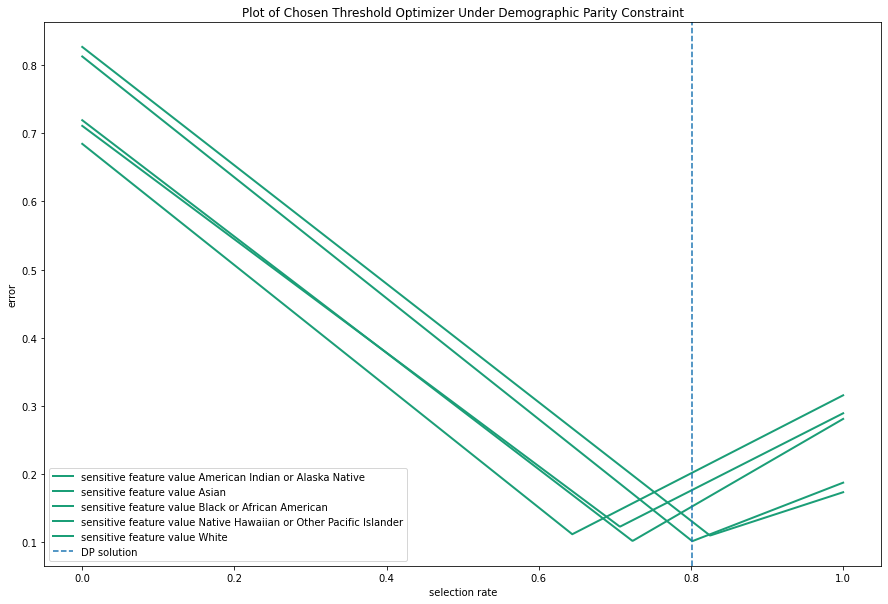

In [38]:
plt.figure(figsize=(15, 10))
plt.title('Plot of Chosen Threshold Optimizer Under Demographic Parity Constraint')
plot_threshold_optimizer(optimizer, ax=plt.axes())

In [39]:
dpd = demographic_parity_difference(y_test_target, prediction_dp, sensitive_features = X_test_race)
eod = equalized_odds_difference(y_test_target, prediction_dp, sensitive_features = X_test_race)
dpr = demographic_parity_ratio(y_test_target, prediction_dp, sensitive_features = X_test_race)

print("Demographic parity difference: {}".format(round(dpd, 2)))
print("Equalized odds difference: {}".format(round(eod, 2)))
print("Demographic parity ratio: {}".format(round(dpr, 2)))

Demographic parity difference: 0.02
Equalized odds difference: 0.1
Demographic parity ratio: 0.98


In [40]:
FairlearnDashboard(y_true = y_test_target,
                   y_pred = {"prediction_original" : pred_y_test,
                             "prediction_dp": prediction_dp,
                             "prediction_opt": prediction_opt,
                             "prediction_eo": prediction_eo},
                   sensitive_features = X_test_race,
                   sensitive_feature_names = ["race"])

FairlearnWidget(value={'true_y': [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1…

### Visualizing Results

In [50]:
int_df = pd.concat([X_test_race, X_test_sex], axis=1)

int_df['prediction'] = prediction_dp

int_df.head()

,applicant_race_name_1,applicant_sex_name,prediction
342444,Asian,Male,1
365643,White,Male,1
315751,Asian,Male,1
673351,White,Male,0
158651,White,Female,1


In [51]:
race_sex_dict = {}
for i in int_df['applicant_race_name_1'].unique():
    curr_df = int_df[int_df['applicant_race_name_1'] == i]
    
    male_df = curr_df[curr_df['applicant_sex_name'] == 'Male']
    female_df = curr_df[curr_df['applicant_sex_name'] == 'Female']
    
    male_prop = male_df[male_df['prediction'] == 1].shape[0] / male_df.shape[0]
    female_prop = female_df[female_df['prediction'] == 1].shape[0] / female_df.shape[0]
    
    race_sex_dict[i] = {'Male': male_prop, 'Female': female_prop}

In [52]:
race_names = []
males_props = []
females_props = []
for key in race_sex_dict:
    race_names.append(key)
    males_props.append(race_sex_dict[key]['Male'])
    females_props.append(race_sex_dict[key]['Female'])

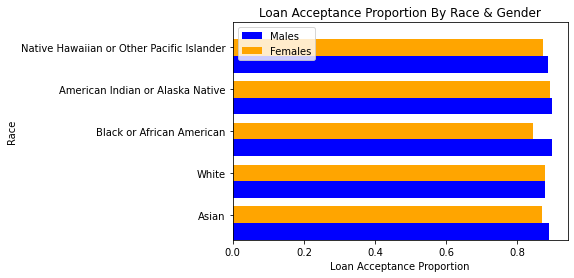

<Figure size 1296x720 with 0 Axes>

In [63]:
ind = np.arange(len(race_names))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, males_props, width, color='blue', label='Males')
ax.barh(ind + width, females_props, width, color='orange', label='Females')
plt.ylabel('Race')
plt.xlabel('Loan Acceptance Proportion')
plt.title('Loan Acceptance Proportion By Race & Gender')

ax.set(yticks=ind + width, yticklabels=race_names, ylim=[2*width - 1, len(race_names)])
ax.legend(loc='upper left')

plt.figure(figsize=(18, 10))

plt.show()